In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import StratifiedKFold

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

np.random.seed(42)


In [299]:
train = pd.read_csv('feat_sel_training_data.csv')
test = pd.read_csv('feat_sel_testing_data.csv')


___ 

## Data preprocessing

We need to scale our numeric data so that we don't get overweighting in some models. We will use a MinMaxScaler to scale between 0 and 1, meaning that we won't affect our One-Hot Encoded columns

In [300]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   accident_year                            11337 non-null  int64 
 1   number_of_vehicles                       11337 non-null  int64 
 2   number_of_casualties                     11337 non-null  int64 
 3   first_road_class                         11337 non-null  object
 4   road_type                                11337 non-null  object
 5   speed_limit                              11337 non-null  int64 
 6   junction_detail                          11337 non-null  object
 7   second_road_class                        11337 non-null  object
 8   pedestrian_crossing_physical_facilities  11337 non-null  object
 9   light_conditions                         11337 non-null  object
 10  urban_or_rural_area                      11337 non-null  o


Speed limit, Years, and age_bands should be categorical and ordered.



In [301]:
speed_lims = train.speed_limit.value_counts().sort_index().index
years = train.accident_year.value_counts().sort_index().index
age_bands = ['0 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 65', '66 - 75', 'Over 75']

for data in [train, test]:
  data['speed_limit'] = pd.Categorical(values=data['speed_limit'], categories=speed_lims, ordered=True)
  data['accident_year'] = pd.Categorical(values=data['accident_year'], categories=years, ordered=True)
  data['age_band_of_casualty'] = pd.Categorical(data['age_band_of_casualty'], ordered=True, categories=age_bands)



We don't really want to encode our date/time features as numeric as we will impose restrictions on our model, i.e. expecting severity to linearly increase with hour. Let's sin/cosine encode it for now to preserve the cyclical nature, but potentially we should bucket the Hours and Months.

In [302]:
# please forgive me for this horrible breach of the DRY principle
for data in [train, test]:
  data['day_sin'] = np.sin(data['Day'] * (2 * np.pi / data['Day'].max()))
  data['day_cos'] = np.cos(data['Day'] * (2 * np.pi / data['Day'].max()))
  data['month_sin'] = np.sin(data['Month'] * (2 * np.pi / data['Month'].max()))
  data['month_cos'] = np.cos(data['Month'] * (2 * np.pi / data['Month'].max()))
  data['hour_sin'] = np.sin(data['Hour'] * (2 * np.pi / data['Hour'].max()))
  data['hour_cos'] = np.cos(data['Hour'] * (2 * np.pi / data['Hour'].max()))
  data.drop(columns=['Day', 'Month', 'Hour'], axis=1, inplace=True)

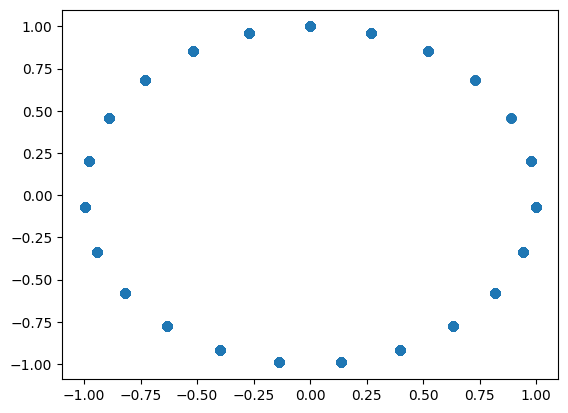

In [303]:
plt.scatter(train['hour_sin'], train['hour_cos'])


* Numeric features need scaling
* Ordinal features need numerical encoding
* Nomial features can be one-hot-encoded

In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   accident_year                            11337 non-null  category
 1   number_of_vehicles                       11337 non-null  int64   
 2   number_of_casualties                     11337 non-null  int64   
 3   first_road_class                         11337 non-null  object  
 4   road_type                                11337 non-null  object  
 5   speed_limit                              11337 non-null  category
 6   junction_detail                          11337 non-null  object  
 7   second_road_class                        11337 non-null  object  
 8   pedestrian_crossing_physical_facilities  11337 non-null  object  
 9   light_conditions                         11337 non-null  object  
 10  urban_or_rural_area               

In [305]:
boolean_feats = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
     
for dataset in [train, test]:
  for col in boolean_feats:
    dataset[col].replace({dataset[col].value_counts().index[0]: 0, dataset[col].value_counts().index[1]: 1}, inplace=True)

    
numeric_feats = ['number_of_vehicles', 'number_of_casualties']
ordinal_feats = list(train.select_dtypes(include='category').columns)
nominal_feats = list(train.select_dtypes(exclude=[np.number, bool, 'category']).columns)

### Scaling numericals

In [307]:
scaler = MinMaxScaler()
train[numeric_feats] = scaler.fit_transform(train[numeric_feats])
test[numeric_feats] = scaler.transform(test[numeric_feats])

### Ordinal encoding

In [308]:
year_codes = dict(zip(train.accident_year.cat.categories, np.arange(0, len(train.accident_year.cat.categories) + 1, 1)))
speed_limit_codes = dict(zip(train.speed_limit.cat.categories, np.arange(0, len(train.speed_limit.cat.categories) + 1, 1)))
age_band_codes = dict(zip(train.age_band_of_casualty.cat.categories, np.arange(0, len(train.age_band_of_casualty.cat.categories) + 1, 1)))

for data in [train, test]:
  data['accident_year'].replace(year_codes, inplace=True)
  data['speed_limit'].replace(speed_limit_codes, inplace=True)
  data['age_band_of_casualty'].replace(age_band_codes, inplace=True)

In [309]:
for data in [train, test]:
  data[ordinal_feats] = data[ordinal_feats].apply(lambda x: x.cat.codes)

#### One-hot encoding

In [310]:
train = pd.get_dummies(train, columns=nominal_feats)
test = pd.get_dummies(test, columns=nominal_feats)


In [311]:
(train.columns == test.columns).all()

True

In [312]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 63 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   accident_year                                                                                                      11337 non-null  int8   
 1   number_of_vehicles                                                                                                 11337 non-null  float64
 2   number_of_casualties                                                                                               11337 non-null  float64
 3   speed_limit                                                                                                        11337 non-null  int8   
 4   urban_or_rural_area   

So we've got 59 total features, along with out predictor. Let's see what happens when we test some different models.

___
## Initial modelling

In [313]:
y_train = train['casualty_severity']
X_train = train.drop('casualty_severity', axis=1)

y_test = test['casualty_severity']
X_test = test.drop('casualty_severity', axis=1)

In [314]:
def evaluate_model(model_class, X_train=X_train, y_train=y_train):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    # Stratified K fold cross validation and predict on training data
    accuracy_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='accuracy') * 100
    precision_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='precision') * 100
    recall_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='recall') * 100
    f1_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='f1') * 100
    

    metrics_dict = {
        'Model Type': model_class,
        'CV_mean_accuracy': np.round(accuracy_scores.mean(), 1), 
        'CV_mean_precision':np.round(precision_scores.mean(), 1), 
        'CV_mean_recall': np.round(recall_scores.mean(), 1), 
        'CV_mean_F1': np.round(f1_scores.mean(), 1)
        
       
    }   

    return metrics_dict

In [315]:
models = {'KNN': KNeighborsClassifier(), 'Logistic Regression': LogisticRegression(), 'Random Forest': RandomForestClassifier(), 'XGBoost': XGBClassifier()}  
model_metric_dict = {}

for key, values in models.items():
  pred = values.fit(X_train, y_train).predict(X_train)
  print(f"\nClassification Report ({key}):")
  print(classification_report(y_train, pred))


Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      8156
           1       0.72      0.53      0.61      3181

    accuracy                           0.81     11337
   macro avg       0.78      0.72      0.74     11337
weighted avg       0.80      0.81      0.80     11337


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      8156
           1       0.55      0.14      0.22      3181

    accuracy                           0.73     11337
   macro avg       0.65      0.55      0.53     11337
weighted avg       0.69      0.73      0.66     11337


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8156
           1       1.00      1.00      1.00      3181

    accuracy                           1.00     11337
   macro avg

In [316]:
for key, values in models.items():
  metrics_dict = evaluate_model(values)
  model_metric_dict.update({key: metrics_dict})

results = pd.DataFrame.from_dict(model_metric_dict).T.round(2)
results.sort_values(by='CV_mean_recall', ascending=False)

,Model Type,CV_mean_accuracy,CV_mean_precision,CV_mean_recall,CV_mean_F1
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",77.1,64.3,43.6,52.1
Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",80.8,77.5,42.8,56.2
KNN,KNeighborsClassifier(),71.0,48.8,32.3,38.8
Logistic Regression,LogisticRegression(),72.4,54.1,13.7,21.6


### We're clearly __massively__ overfitting to our training data. With our RF classifier, we have nearly 100% f1 score (the model predicts the correct outcome for every collision) without any cross-fold validation. With 5-fold stratified cross-validation, the f1 score of our RF model drops to 56%.

Despite the overfitting, the CV scores are much better than the dummy classifier model (yay!). The stratified dummy predictor gave an F1 score of 0.28 - we are at 0.52 and 0.56 for our XGboost and Random Forest models. The KNN model also beat the dummy performance, woohoo.

As expected for a dataset with so many categorical features, the tree-based models are outperforming the KNN and logistic regression models. ALthough the random forest has given a higher F1 score than the XGboost, I think I will continue with the XGBoost model as it is typically quite good with imbalanced datasets


We are definitely still overfitting to our training data, so let's try some Recursive Feature Elimination and see how many features are actually important.

After this, we can revisit our feature selection and engineering and see if we can reduce the overfitting before we evalute this model on our testing data - at the moment it is likely to perform quite badly.

In [317]:
from sklearn.feature_selection import RFE

f1_scores = []

model_selected = XGBClassifier(random_state=42)
for n_feats in np.arange(1, X_train.shape[1], 5):
  rfe = RFE(estimator=model_selected, n_features_to_select=n_feats)
  rfe.fit(X_train, y_train)
  model_selected.fit(X_train.loc[:, rfe.support_], y_train)
  y_pred_selected = model_selected.predict(X_train.loc[:, rfe.support_])
  f1_selected = f1_score(y_train, y_pred_selected)
  f1_scores.append(f1_selected)

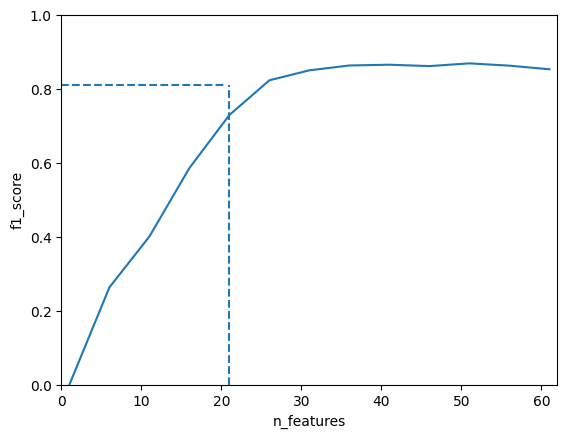

In [318]:
x = np.arange(1, X_train.shape[1], 5)
plt.plot(x, f1_scores)
plt.ylim(0, 1)
plt.xlim(0, X_train.shape[1])
plt.xlabel('n_features')
plt.ylabel('f1_score')
plt.axhline(0.81, xmax=0.33, linestyle='--')
plt.axvline(21, ymax=0.81, linestyle='--')


Interesting, on a plot of f1_score vs. n_features we seem to have an inflection point at around 21 features. Let's see what features the RFE model includes with these value of n_features.

In [319]:
rfe = RFE(estimator=model_selected, n_features_to_select=21)
rfe.fit(X_train, y_train)
model_selected.fit(X_train.loc[:, rfe.support_], y_train)
y_pred_selected = model_selected.predict(X_train.loc[:, rfe.support_])
print(f'f1 score with 21 features: {f1_score(y_train, y_pred_selected)}.') 
print(X_train.loc[:, rfe.support_].columns)

f1 score with 21 features: 0.7295173961840627.
Index(['number_of_vehicles', 'number_of_casualties', 'speed_limit',
       'sex_of_casualty', 'age_band_of_casualty', 'high_winds', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'first_road_class_Motorway',
       'road_type_Single carriageway', 'junction_detail_Crossroads',
       'junction_detail_Roundabout', 'second_road_class_B',
       'pedestrian_crossing_physical_facilities_Pedestrian phase at traffic signal junction',
       'light_conditions_Daylight', 'casualty_class_Passenger',
       'casualty_type_Car occupant', 'casualty_type_Large Vehicle',
       'casualty_type_Motorcycle'],
      dtype='object')
